# Image recognition: An exercise within the framework of module 2 of the CAS in Advanced Machine Learning (university of Bern)

## Credit:
#### Algorithms: 
This notebook is inspired by Lucien Hinderling (group of Olivier Pertz, Institute of Cell Biology, University of Bern) and the notebook he provided: 
https://github.com/hinderling/napari_pixel_classifier/blob/main/napari_pixel_classifier_rgb.ipynb

The method relies on using a pretrained convolutional network (VGG16 by Simonyan and Zisserman; for a description see the notebook by Hinderling mentioned above) for feature extraction and subsequent pixel classification by random forest. 

#### Data:
I work with MRI images of dog knees generously provided by the veterinary hospital of the university of Zurich (thanks to Dr. Henning Richter, Dr. Bart Thomson, and Dr. Brian Park).

In [1]:
#import pydicom
import nibabel as nib

In [2]:
#import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import time
from skimage import io
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from napari.layers import Image, Labels
from csbdeep.utils import normalize
#from magicgui import magicgui
import napari
#import pydicom

In [3]:
import nrrd
import pandas as pd

Ilastik-like pixel classifier
An interactive pixel classifier that uses kernels extracted from a CNN (VGG16 trained on imagenet) instead of traditional filter banks as feature extractors.

## Define functions

In [4]:
#@magicgui(call_button='train classifier')
def clf_widget():
    '''GUI widget to train the classifier.
       Trains the classifier based on the annotations made,
       and predicts the class for all pixels in the rest of the image.
    '''
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, img[:,:,0].shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def fd_VGG16_scaled(img,model,shape):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    #resize image to new shape  
    img_scaled = tf.image.resize(img,shape)
    img_scaled = np.array(img_scaled)
    stacked_img = img_scaled.reshape(-1, shape[0], shape[1], 3)
    
    #predict class in keras for each pixel
    features=model.predict(stacked_img)
    fv_VGG16= np.squeeze(features) #remove extra dim
    #scale up to match original img size
    fv_VGG16 = tf.image.resize(fv_VGG16,(img.shape[0],img.shape[1])) 
    return fv_VGG16


def fd_VGG16_pyramid(img,models,shapes):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for model,shape in zip(models,shapes):
        fv = fd_VGG16_scaled(img,model,shape)
        fv_list.append(fv)
    global_feature = np.concatenate(fv_list,axis=2)
    return global_feature    


def init_VGG16_pyramid(input_shapes):
    '''Download the pretrained VGG16 weights trained on imagenet. Cut off all 
    layers except the first conv2 block. Repeat for all input scales.
    '''
    models = []
    for shape in input_shapes:
        keras_shape = (shape[0],shape[1],3) #add color channel
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=keras_shape)
        #VGG_model.summary()

        #disable training (use pretrained weights)
        for layer in VGG_model.layers:
            layer.trainable = False

        #only use up to last layer where input size is still 1024x1024
        new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
        models.append(new_model)
    return models


def annotations_to_tensor(feature_matrix,mask):
    '''Convert the user annotated labels from napari to tensors to train the the classifier on.
    feature matrix dim: [x,y,nb_features]
    possible mask elements: 0: not annotated, int[1,2]: class annotation
    '''
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        X_features.append(feature_matrix[x,y,:])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

In [5]:
def grayscale_to_rgb(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=-1)
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

In [6]:
def prep_train_data(array):
    # Make a copy of the slice to use as training data features:
    train_data_X = array.copy()
    # Remove the annotation and set the values 0 and 1:
    train_data_X[train_data_X==3] = 0
    train_data_X[train_data_X==2] = 1
    # Make a second copy of the slice to use as training data labels:
    train_data_y = array.copy()
    # Set every value to zero except for the annotation:
    train_data_y[train_data_y!=3] = 0
    train_data_y[train_data_y==3] = 1

    return train_data_X, train_data_y
    

In [7]:
def prep_test_data(array):
    # Make a copy of the slice to use as training data features:
    test_data_X = array.copy()
    # Remove the annotation and set the values 0 and 1:
    test_data_X[test_data_X==3] = 0
    test_data_X[test_data_X==2] = 1

    return test_data_X

In [8]:
def plot_slices(ix_start, ix_end, images_per_row, array, dimension):
    #ix_start = 268
    #ix_end = 286
    
    # Number of images to plot
    n_images = ix_end - ix_start
    
    # Number of images per row
    #images_per_row = 3
    
    # Calculate the number of rows needed
    n_rows = (n_images + images_per_row - 1) // images_per_row  # This rounds up
    
    # Adjust the figure size for larger images (you can tweak the numbers)
    fig, axs = plt.subplots(nrows=n_rows, ncols=images_per_row, figsize=(12, n_rows * 4))
    
    # Flatten the axes array for easy indexing
    axs = axs.flatten()
    
    for i, ix in enumerate(range(ix_start, ix_end)):
        if i < len(axs):
            # slice_0 = array[ix, :, :]
            if dimension == 0:
                slice_0 = array[ix, :, :]
            elif dimension == 1:
                slice_0 = array[:, ix, :]
            elif dimension == 2:
                slice_0 = array[:, :, ix]
    
            # Plot the slice on the corresponding subplot
            axs[i].imshow(slice_0, cmap='gray', origin='lower')
            axs[i].set_title(f'Slice {ix}')
            axs[i].axis('off')  # Turn off axis labels for better viewing
            
    # Turn off unused subplots if there are any
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [9]:
def test_plot_result(test_image, scaling_factors, classifier):
    # Prepare test data for use with the convolutional network (3 channels needed):
    test_image_3channels = grayscale_to_rgb(test_image)
    # create feature extractor and apply 
    shapes = []
    for i in scaling_factors:
        shapes.append((int(test_image_3channels.shape[0]/i),(int(test_image_3channels.shape[1]/i))))
    print("Image input scales:")
    print(shapes)
    models = init_VGG16_pyramid(shapes)
    features_test_0 = fd_VGG16_pyramid(test_image_3channels,models,shapes)
    # plot example filter response; choose a channel (100) for plotting: 
    plt.imshow(features_test_0[:,:,100])
    plt.show()
    
    # Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
    X_test = features_test_0.reshape(-1, 192)  # Shape: (271040, 192)
    # Use the trained random forest classifier to make predictions:
    predictions = classifier.predict(X_test)
    # Assuming `predictions` is a 1D array of length corresponding 
    # to the product of the original image dimensions:
    # len(predictions) = test_image.shape[0] * test_image.shape[1] :
    predictions_reshaped = predictions.reshape(test_image.shape[0], test_image.shape[1])
    
    # Plot the reshaped predictions
    plt.imshow(predictions_reshaped, cmap='gray')
    plt.title('Predicted Segmentation')
    plt.show()

## Description of the data and the project:
I am working with MRI images of dog knees with the goal of automating the segmentation of the meniscus. 
The meniscus is an anatomical structure located between the bones of the upper thigh and the lower leg (femur and tibia respectively). MRI highlights tissue with high water content (hydrogen atoms). The meniscus tissue is not highlighted. In an MRI image, the menisci are therefore located in the croissant shaped black spaces (see image below). The black spaces, however, are not completely filled with the meniscus as there are gaps between it and sorrounding tissue as well as areas where the meniscus transitions into ligaments. Therefore simply detecting the black surfaces would not be accurate. Instead, we have to use our preconceived notion of the meniscus shape based on anatomical knowledge when annotating. I therefore had to do the annotation manually using the free software 3d-slicer: https://www.slicer.org/ . 

At the moment MRI images of only one dog knee are available, which limits the training of segmentation algorithms. The present notebook therefore only is a first attempt at using automated segmentation methods.

As I progress with data annotation, hopefully more data will become available. The long term goal would be to automate the segmentation process, which otherwise would have to be done manually by a human expert. 

## Description of the segmentation method:
Following the approach suggested by Lucien Hinderling, I use the first two convolutional layers of the VGG16 CNN with training deactivated (transfer learning) in order to identify the image features. Subsequently, a Random Forest classifier is trained on the features to classify every pixel as either belonging to the meniscus (object to be segmented) or not. 

In order to mitigate the small filter size, the image is downscaled by three different factors and for each image scale feature extraction is performed (as the image is made smaller the filter will be bigger relative to the image). 

The first two convolutional layers of VGG16 contain 64 filters each, always of size 3X3 with stride length 1. Padding is set to preserve the spatial resolution of the image given the filter size 3X3. In every layer every convolution output value is fed into a ReLU activation function. For details see: 
https://arxiv.org/pdf/1409.1556
or https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918 


### Raw image (without annotation) of the two menisci (coronal view, MRI image) :

In [10]:
# Load raw data without annotation as an illustrative example:
data, header = nrrd.read('DataRawSegmentation.seg.nrrd')
# Create a NIfTI image
img_raw = nib.Nifti1Image(data, np.eye(4))
data_raw = img_raw.get_fdata()
data_raw.shape

(560, 560, 484)

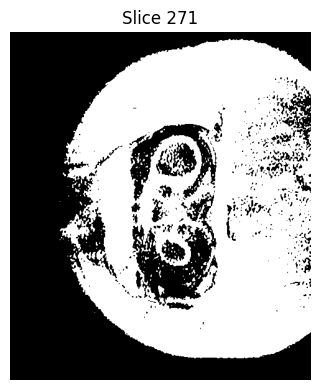

In [11]:
plot_slices(ix_start = 271, ix_end = 272, images_per_row = 2, 
            array = data_raw, dimension = 1)

### Load the annotated data:

In [12]:
file_path = 'DIRU_2022_04_dog_03_E_nc/medialis/03_E_nc_med_Segmentation.seg.nrrd'
#file_path = 'DIRU_2022_04_dog_03_E_nc/medialis_test/03_E_nc_med_Segmentation_test.seg.nrrd'

In [13]:
# Load the NRRD file
data, header = nrrd.read(file_path)

# Create a NIfTI image
img = nib.Nifti1Image(data, np.eye(4))

# Save the image in NIfTI format
# nib.save(img, 'output.nii.gz')

In [14]:
data = img.get_fdata()

In [15]:
data.shape

(4, 560, 560, 484)

#### Choose the channel that contains the annotated meniscus and the background data:

In [16]:
data_ex = data[0, :, :, :]
#data_ex = data[ :, :, :]

In [17]:
data_ex.shape

(560, 560, 484)

#### Choose appropriate 2-dimensional slices out of the 3-dimensional data where the annotated meniscus is visible:
The data is three-dimensional, for a start I choose to work with two dimensional data. I therefore choose some slices out of the 3-dimensional data where the meniscus is recognizable (due to annotation) in the coronal view.

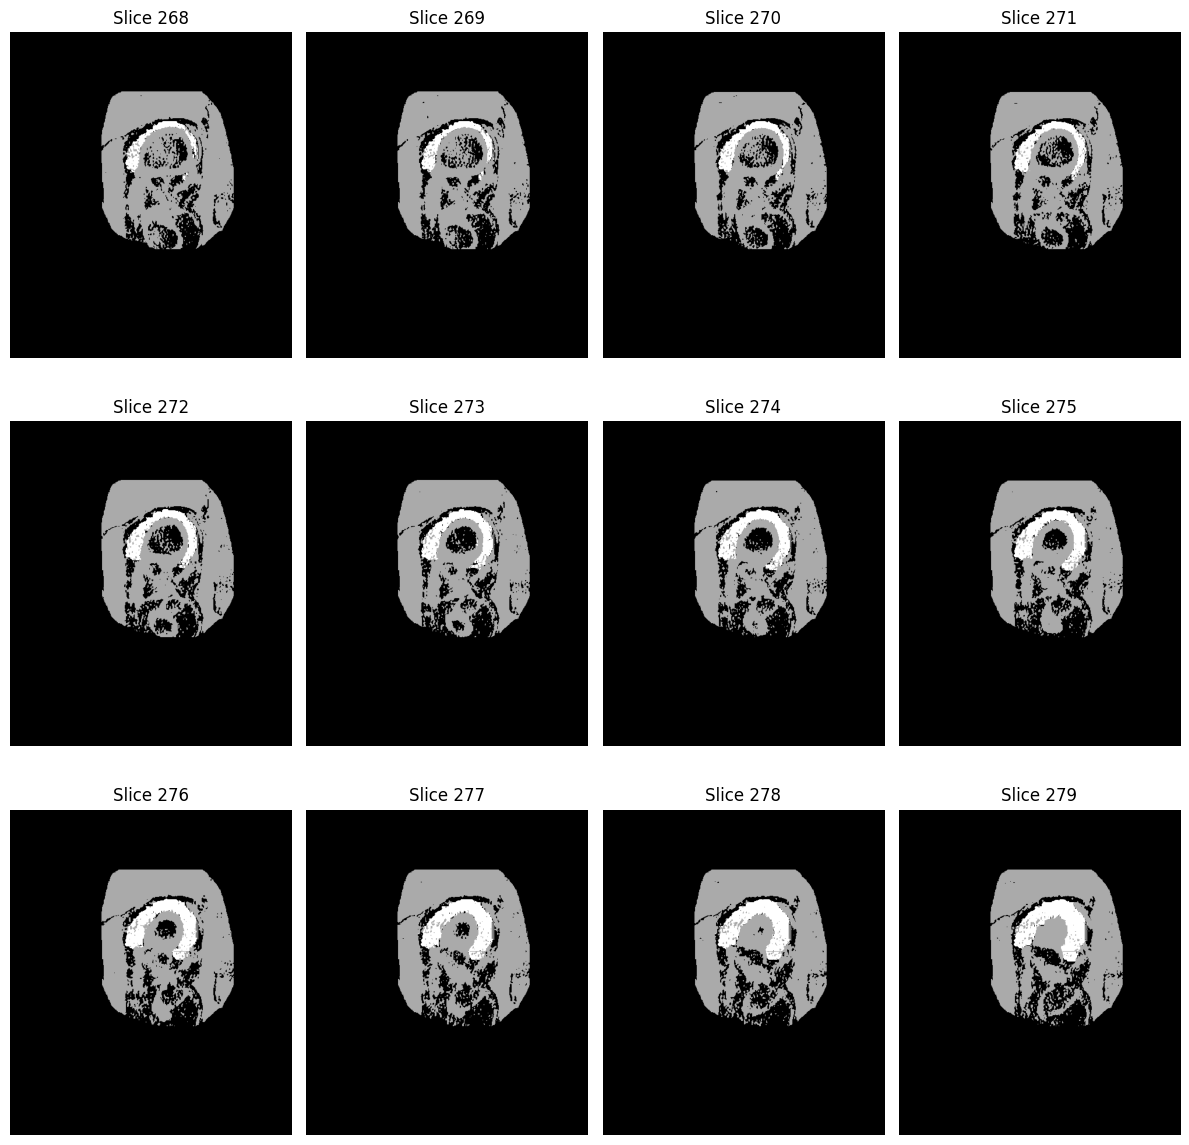

In [18]:
plot_slices(ix_start = 268, ix_end = 280, images_per_row = 4, 
            array = data_ex, dimension = 1)

## Experiment 1:
 Training on regular croissant shape and testing on three different cases: One similar to the training shape and two that are deviating significantly from the regualar croissant shape to see how the algorithm copes with that. The expectation is that the classifier would do best on the test image that is similar to the taining image and would do less well on the test images that deviate from the regular croissant shape.

#### Choose slice from the middle with a nice croissant shape for training:

In [19]:
np.unique(data_ex[:, 281, :], return_counts=True)

(array([0., 2., 3.]), array([228041,  36988,   6011]))

In [20]:
# Choose a slice from the middle: 
example_slice = data_ex[:, 281, :].copy()

In [21]:
np.unique(example_slice)

array([0., 2., 3.])

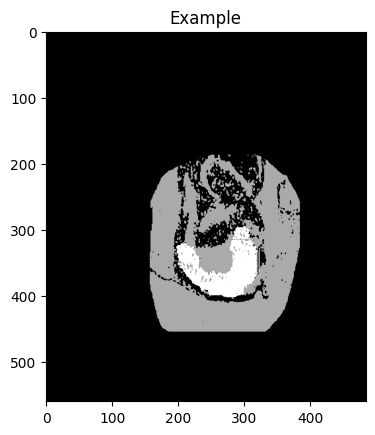

In [22]:
plt.imshow(example_slice, cmap='gray')
plt.title('Example')
plt.show()

#### Prepare training data:
The function prep_train_data: Makes two copies, removes the annotation from one (pixel intensities), and removes everything except the annotation from the other (labels). 

In [23]:
slice_train, labels_train = prep_train_data(example_slice)

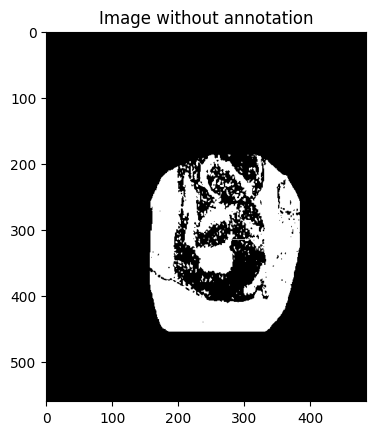

In [24]:
plt.imshow(slice_train, cmap='gray')
plt.title('Image without annotation')
plt.show()

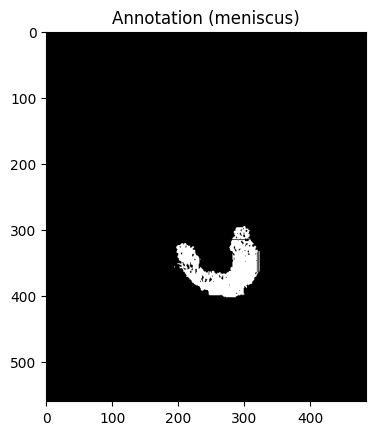

In [25]:
plt.imshow(labels_train, cmap='gray')
plt.title('Annotation (meniscus)')
plt.show()

In [26]:
print(np.unique(slice_train))
print(np.unique(labels_train))

[0. 1.]
[0. 1.]


#### Choose one slice from the middle (with a regular croissant shape) and fringe slices where the croissant shape of the meniscus is less regular as test data:

In [27]:
example_slice_0 = data_ex[:, 280, :].copy()

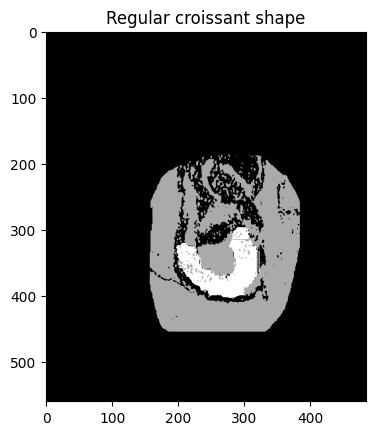

In [28]:
plt.imshow(example_slice_0, cmap='gray')
plt.title('Regular croissant shape')
plt.show()

In [29]:
example_slice_1 = data_ex[:, 285, :].copy()
np.unique(example_slice_1)

array([0., 2., 3.])

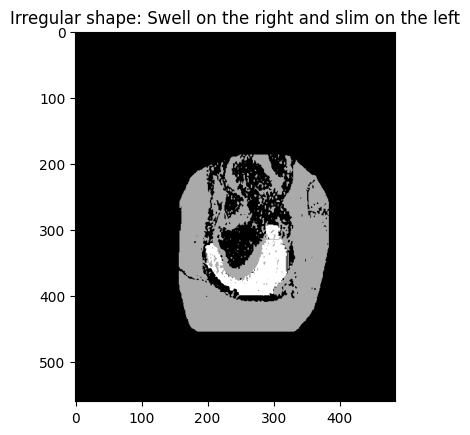

In [30]:
plt.imshow(example_slice_1, cmap='gray')
plt.title('Irregular shape: Swell on the right and slim on the left')
plt.show()

In [31]:
slice_test_1 = prep_test_data(example_slice_1)

In [32]:
example_slice_2 = data_ex[:, 270, :].copy()

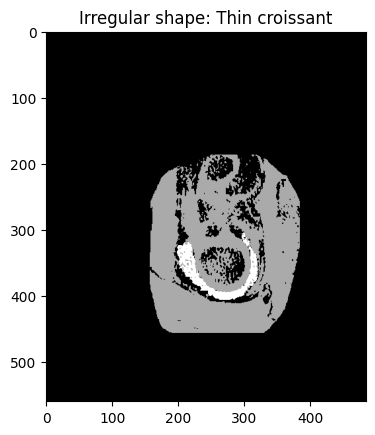

In [33]:
plt.imshow(example_slice_2, cmap='gray')
plt.title('Irregular shape: Thin croissant')
plt.show()

#### Prepare test data:
The function prep_test_data removes the annotation (by setting its values to 0) and and sets the rest of the values to 1 or 0.

In [34]:
slice_test_0 = prep_test_data(example_slice_0)
slice_test_1 = prep_test_data(example_slice_1)
slice_test_2 = prep_test_data(example_slice_2)

#### Prepare training data for use with pretrained, frozen convolutional network:
Only works with 3-channel data. If it's grayscale data, just stack the image 3 times using the function `grayscale_to_rgb()`.

In [35]:
img = grayscale_to_rgb(slice_train)
#img = grayscale_to_rgb(slice_train)
#img = grayscale_to_rgb(slice_test_t)

#### Define downscaling factors to use on image:

In [36]:
downscaling_factors = [1,2,4]

#### Extract the features using convolutional filters extracted from a VGG16

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


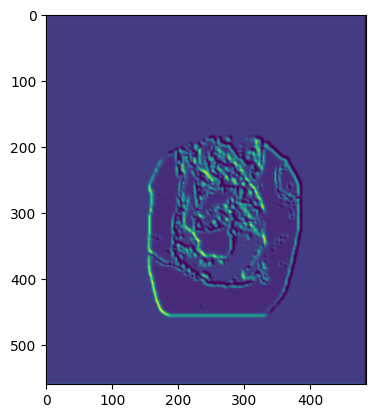

In [37]:
# create feature extractor and apply 
shapes = []
for i in downscaling_factors:
    shapes.append((int(img.shape[0]/i),(int(img.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(img,models,shapes)
# plot example filter response
plt.imshow(features[:,:,100])
plt.show()

#### Prepare output from the convolutional network for use with random forest:

In [38]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X = features.reshape(-1, 192)  # Shape: (271040, 192)
# Flatten the labels
y = labels_train.ravel()  # Shape: (271040,)

#### Train the random forest classifier:

In [39]:
#create the classifier
clf_1 = RandomForestClassifier(random_state=0)
clf_1.fit(X, y)

RandomForestClassifier(random_state=0)

#### Test classification algorithm with test slice 0 (with the regular croissant shape):

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


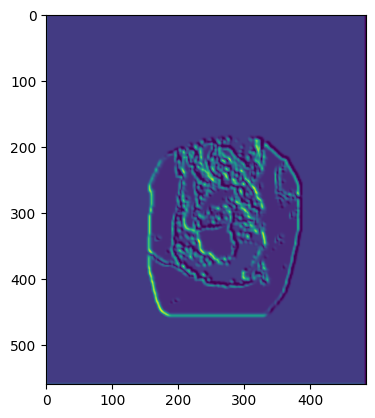

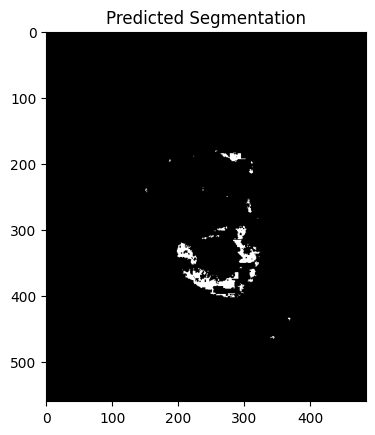

In [40]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_0, downscaling_factors, clf_1)

#### Test classification algorithm with test slices 1 and 2 (less regular croissant shape):

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


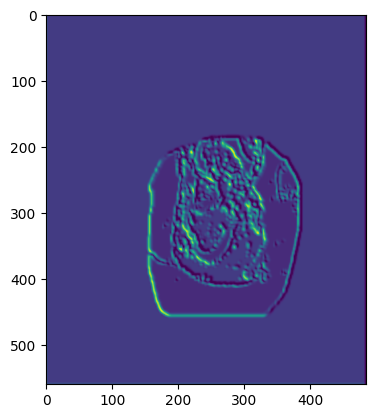

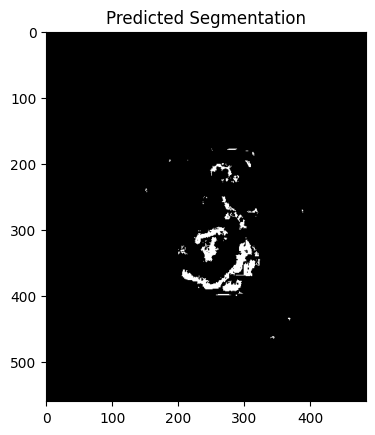

In [41]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_1, downscaling_factors, clf_1)

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


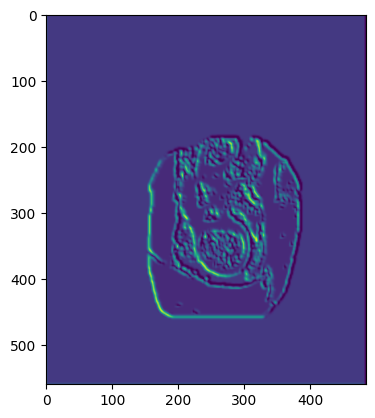

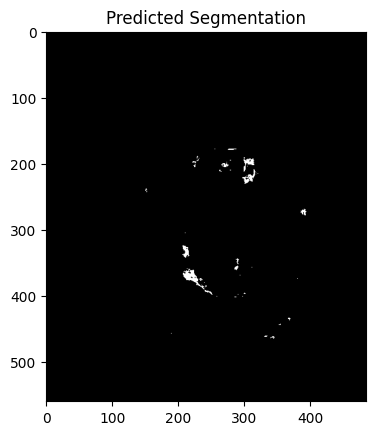

In [42]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_2, downscaling_factors, clf_1)

#### Conclusion: 
Test result on the regular croissant shape resulted in something ressembling vaguely a croissant shape, testing on the fringe cases failed completely.

As mentioned by Hinderling, the small filter size of VGG16 makes it more difficult for the model to recognize larger structures because only immediate neighbourhood is taken into account when extracting the features of each pixel. This is mitigated by applying the first two layers of VGG16 to downscaled versions of the image (filter will be larger relative to the downscaled image). Therefore one would expect the classifier to do better when downscaling the image more. 

## Experiment 2: 
I will carry out the same experiment as above but this time with larger downscaling factors.

In [43]:
downscaling_factors = [4,8,15]

#### Prepare training data: 

In [44]:
slice_train, labels_train = prep_train_data(example_slice)
img = grayscale_to_rgb(slice_train)

#### Extract the features using convolutional filters extracted from a VGG16

Image input scales:
[(140, 121), (70, 60), (37, 32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


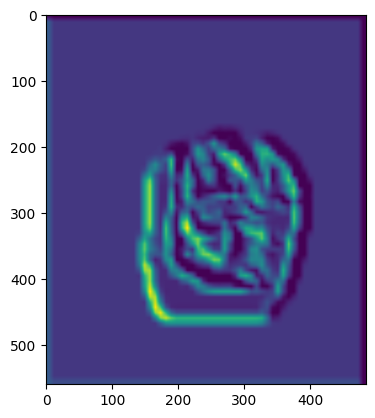

In [45]:
# create feature extractor and apply 
shapes = []
# Use larger downscaling factors 
for i in downscaling_factors:
    shapes.append((int(img.shape[0]/i),(int(img.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(img,models,shapes)
# plot example filter response
plt.imshow(features[:,:,100])
plt.show()

In [46]:
features.shape

(560, 484, 192)

In [47]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X = features.reshape(-1, 192)  # Shape: (271040, 192)
# Flatten the labels
y = labels_train.ravel()  # Shape: (271040,)

#### Train classifier:

In [48]:
clf_2 = RandomForestClassifier(random_state=0)

In [49]:
clf_2.fit(X, y)

RandomForestClassifier(random_state=0)

### Prepare test data:
The function prep_test_data removes the annotation (by setting its values to 0) and and sets the rest of the values to 1 or 0.

In [50]:
slice_test_0 = prep_test_data(example_slice_0)
slice_test_1 = prep_test_data(example_slice_1)
slice_test_2 = prep_test_data(example_slice_2)

#### Test classification algorithm with test slice 0 (with the regular croissant shape):

Image input scales:
[(140, 121), (70, 60), (37, 32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


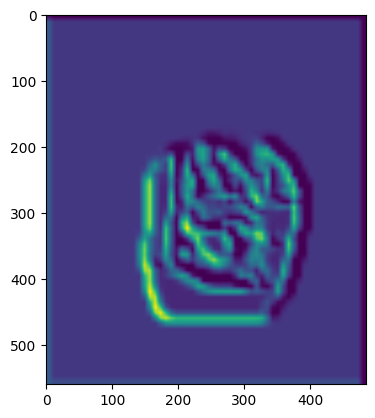

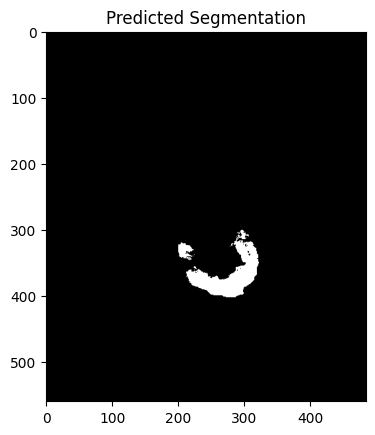

In [51]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_0, downscaling_factors, clf_2)

#### Test classification algorithm with test slices 1 and 2 (less regular croissant shape):

Image input scales:
[(140, 121), (70, 60), (37, 32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


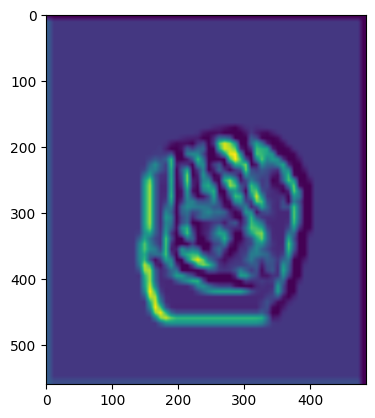

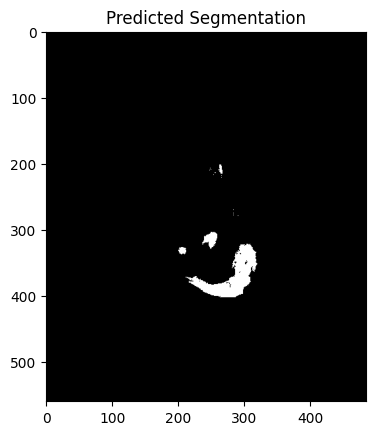

In [52]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_1, downscaling_factors, clf_2)

Image input scales:
[(140, 121), (70, 60), (37, 32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


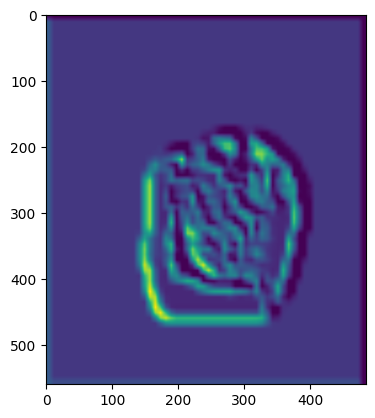

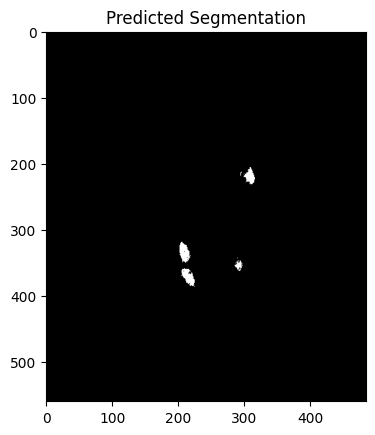

In [53]:
# The function loops through the downscaling factors, scales the test image down
# and carries out feature extraction for each downscaling factors. The output
# for the different downscaling factors is then stacked and fed into the Random Forest classifier.
# Both an example image of the extracted features (one channel is chosen) and the final predictions
# are plotted. 
test_plot_result(slice_test_2, downscaling_factors, clf_2)

#### Conclusion:
This time the algorithm did indeed pick up the croissant shape much better at least in the first two test cases.

## Check model architecture:

In [54]:
models[0].summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 140, 121, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 140, 121, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 140, 121, 64)   │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,720 (151.25 KB)

In [55]:
models[1].summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 70, 60, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 70, 60, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 70, 60, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,720 (151.25 KB)

In [56]:
models[2].summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 37, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 37, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 37, 32, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,720 (151.25 KB)

#### Number of parameters in the first convolutional layer:

In [57]:
filter_width = 3
filter_height = 3
number_of_filters = 64
stride_length = 1
number_of_channels = 3
number_of_activation_functions = number_of_filters # Every filter output value is passed to a ReLU activation function.

In [58]:
filter_width * filter_height * number_of_channels * (number_of_filters/stride_length) + number_of_activation_functions

1792.0

#### Number of parameters in the second convolution layer:

In [59]:
# Number of channels equals number of filters in the previous layer:
number_of_channels = number_of_filters

In [60]:
filter_width * filter_height * number_of_channels * (number_of_filters/stride_length) + number_of_activation_functions

36928.0

The calculated numbers match the numbers indicated by the model summary. -> OK!